Modelo de aprendizaje automatizado supervisado. 

El objetivo es recomendar planes con una exactitud de 0.75. 

Compañía Megaline. 

Planes: Smart o Ultra

In [13]:
#Importación de librerías
import numpy as np
import pandas as pd
#delimitar sklearn
import sklearn
from  sklearn.model_selection import train_test_split, GridSearchCV
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


1. Importar los datos

In [14]:
user_plan_data = pd.read_csv("users_behavior.csv")

user_plan_data es un marco de datos de 3214 registros con 4 columnas:

llamadas, minutos, mensajes, megabytes usados y si es plan ultra o smart 

(columnas nombradas en inglés: 'calls', 'minutes', 'messages', 'mb_used', 'is_ultra')

In [15]:
#Observar los tipos de datos, cantidad de datos y nulos. 
#user_plan_data.info()

2. Segmentación de datos

In [16]:
#Segmentar en conjunto de entrenamiento, validación y prueba por train_test_split() en una tasa 60:20:20

#60-40. 60% entrenar, 40% 
entrenamiento, otros = train_test_split(user_plan_data, test_size = 0.4, random_state = 12345) #otros se dividirá en validación y prueba #stratify = user_plan_data["is_ultra"],

#50% cada una. 20% del total para validación y test.
validacion, prueba = train_test_split(otros, test_size= 0.5,  random_state=12345) #stratify= user_plan_data["is_ultra"],

print("Registros y columnas en datos de entrenamiento: ", entrenamiento.shape)
print("Registros y columnas en datos de validacion: ", validacion.shape)
print("Registros y columnas en datos de prueba: ", prueba.shape)
print()
print("Datos segmentados adecuadamente en tasa 3:1:1 o 60%:20%:20%")

#Separación de los datos en objetivo (variable a explicar) y variables explicativas. La variable a explicar es el plan a recomendar. 
x_entrenamiento = entrenamiento.drop(["is_ultra"], axis=1)
y_entrenamiento = entrenamiento["is_ultra"]
x_validacion = validacion.drop(["is_ultra"], axis=1)
y_validacion = validacion["is_ultra"]
x_prueba = prueba.drop(["is_ultra"], axis=1)
y_prueba = prueba["is_ultra"]


Registros y columnas en datos de entrenamiento:  (1928, 5)
Registros y columnas en datos de validacion:  (643, 5)
Registros y columnas en datos de prueba:  (643, 5)

Datos segmentados adecuadamente en tasa 3:1:1 o 60%:20%:20%


3. Elección de Modelo

Objetivo: Elegir entre si recomendar un plan smart o ultra. 

El tipo de aprendizaje aplicable es supervisado ya que se ha de etiquetar como objetivo si es un plan o el otro.
Y los modelos más viables son de clasificación ya sea regresión logística multinomial, árbol de decisiones o bosque aleatorio. 

Al final se elije aquel que presente un mejor desempeño conforme a las métricas, usualmente bosque aleatorio genera un mejor modelo acarreando la desventaja de requerir mayores recursos computacionales o ser más lento. 

In [17]:
#Busqueda de hiperparámetros manual: por loops for. 
mejor_puntaje = 0
mejor_cantidad_arboles = 0
mejor_profundidad = 0
for n_arboles in range(1, 31): # Revisar el modelo con una cantidad de árboles variantes. 
    for profundidad in range(1, 11):
        modelo = RandomForestClassifier(random_state=12345, n_estimators= n_arboles, class_weight="balanced", max_depth=profundidad)
        modelo.fit(x_entrenamiento, y_entrenamiento) # entrena el modelo con datos de entrenamiento
        puntaje = modelo.score(x_validacion, y_validacion) # calcula la puntuación de exactitud (aciertos en predicción) en el conjunto de validación
        if puntaje > mejor_puntaje:
            mejor_puntaje = puntaje # guarda la mejor puntuación de exactitud en el conjunto de validación
            mejor_cantidad_arboles = n_arboles # guarda el número de estimadores para la mejor puntuación de exactitud
            mejor_profundidad = profundidad
            mejor_modelo = modelo
print("La mejor combinación de número de árboles y profunidad por loop for genera una exactitud en el conjunto de validación es: (número de árboles = {}), profundidad:{} exactitud:{:.2f}".format(mejor_cantidad_arboles, mejor_profundidad, mejor_puntaje))

La mejor combinación de número de árboles y profunidad por loop for genera una exactitud en el conjunto de validación es: (número de árboles = 13), profundidad:10 exactitud:0.79


Buscar por códigos emplea menos recursos computacionales sobre todo si no se usa la exploración de una gama abundante de valores en todos los hiperparámetros. El mejor resultado sin ocupar recursos computacionales exhaustivos (<1 minuto>) fue de 79% de exactitud, más adelante tiene un 78.85% de exactitud con los datos de validación mostrándo ser estable, poco variable.

In [ ]:
#Modelo de bosque aleatorio. 
#Método 2 de búsqueda de hiperparámetros: GridSearchCV. 
#Es el método por excelencia para encontrar los mejores hiperparámetros y generar los mejores modelos. 

# Definir el modelo base
modelo = RandomForestClassifier(random_state=12345, class_weight="balanced")

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Cantidad de árboles
    'max_depth': [5, 10, 20, None],  # Profundidad máxima
    'criterion': ['gini', 'entropy'],  # Criterio de división
    'min_samples_split': [2, 5, 10, None],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2, 4, None],  # Muestras mínimas en cada hoja
    'max_features': ['sqrt', 'log2']  # Número de características a considerar
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='accuracy',  # Se usa "accuracy" como métrica de evaluación
    cv=5,  # Validación cruzada con 5 folds
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2  # Mostrar el progreso de la búsqueda
)

# Entrenar el modelo con la búsqueda de hiperparámetros
grid_search.fit(x_entrenamiento, y_entrenamiento)

# Obtener los mejores hiperparámetros
mejor_params = grid_search.best_params_
mejor_puntaje = grid_search.best_score_

# Imprimir resultados
print(f"Mejores hiperparámetros: {mejor_params}")
print(f"Mejor exactitud en validación cruzada: {mejor_puntaje:.2f}")

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits
Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Mejor exactitud en validación cruzada: 0.82


c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2240 fits failed out of a total of 5120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
960 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "

In [21]:
#Generar el mejor modelo con los resultados de GridSearchCV
mejor_modelo = RandomForestClassifier(random_state=12345, class_weight="balanced", n_estimators=10, criterion = "entropy", max_depth= 5, min_samples_leaf=1, min_samples_split=2)
mejor_modelo.fit(x_entrenamiento, y_entrenamiento) # entrena el modelo con datos de entrenamiento

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, n_estimators=10, random_state=12345)

La generación del modelo mediante la búsqueda de hiperparámetros por GridSearchCV generó un 82% de exactitud en valores de entrenamiento. 

Siguiente paso. Poner a prueba el modelo buscando ver que se comporte con una exactitud similar. 

4. Parámetros de calidad. 

Exactitud de la prueba: 79.94%

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       440
           1       0.74      0.57      0.64       203

    accuracy                           0.80       643
   macro avg       0.78      0.74      0.75       643
weighted avg       0.79      0.80      0.79       643



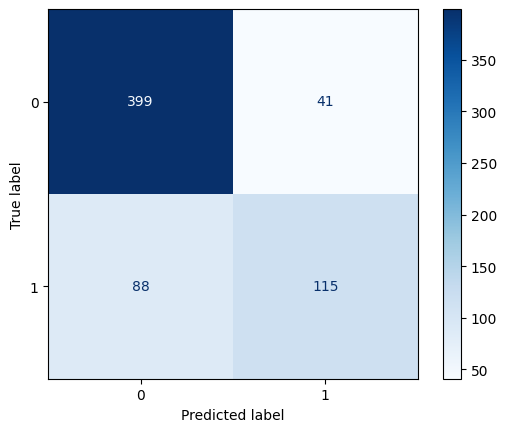

In [22]:
#Poner a prueba el modelo con los datos de prueba. 
y_prediccion = mejor_modelo.predict(x_prueba)
puntaje_prueba = mejor_modelo.score(x_prueba, y_prueba)
print(f"Exactitud de la prueba: {puntaje_prueba*100:.2f}%")
print()
print("Reporte de clasificación: \n", classification_report(y_prueba, y_prediccion))

cm = confusion_matrix(y_prueba, y_prediccion)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")

La revisión de cordura del modelo demuestra que el modelo tiene una exactitud del 79.94% en datos de validación. 

En el modelo presente no es particularmente alarmante eficientizar al modelo para evitar particularmente ya sea falsos positivos ni falsos negativos son de importancia similar, la prioridad es asignar incluso predecir el plan idóneo del consumidor conforme a sus patrones de consumo. 

El modelo asigna adecuadamente al 79.94% de los clientes en su plan ideal respectivo sin embargo es particularmente mejor (f1-score 86%) en asignar clientes al plan smart que al plan ultra (f1-score 64%). 

El modelo genera más falsos positivos, lo que significa que clasifica como "Ultra" casos que en realidad son "Smart", con una tasa de error del 26.3%. En contraste, la tasa de falsos negativos es mucho menor, alrededor del 18.1%, lo que indica que el modelo rara vez clasifica como "Smart" casos que en realidad son "Ultra". 


Conclusión
Se generó un modelo de predicción supervisado basado en bosque aleatorio. 

El modelo llegó a un 79.94% de exactitud sin cambiar relevantemente entre datos de entrenamiento, prueba y validación: de 82% a 79.94%. 
El modelo es particularmente mejor para asignar el plan smart 86% en contraste con 64% del plan ultra. 

Enriquecer el análisis con variables que incluyan cálculos de costos de acuerdo al consumo por usuario debería permitir entender mejor por que es más complicado encontrar patrones de comportamiento en los clientes del plan ultra y particularmente recomendar planes con mayor robustez de manera automatizada fundamentada en otorgar valor al cliente proporcionando la mayor taza de costo beneficio. 